# Manifold Learning

<h3><span style="color:blue">
NOTE:
In this code, all inputs and outputs are <i>column vectors</i>.<br/>
</span></h3>

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Part 1.  Multidimensional Scaling

In [4]:
from sklearn.metrics.pairwise import euclidean_distances

# Helper functions & Datasets
from Code.optimization import gradient_descent 
from Code.dataset import ten_city, synthetic_spiral

## * Classical MDS

### <span style="color:red">============= Assignment 1 =============</span>

In [5]:
def cmds(X, n_dim, input_type='raw'):
    
    """
    Classical(linear) multidimensional scaling (MDS)
    
    Parameters
    ----------
    X: (d, n) array or (n,n) array
        input data. The data are placed in column-major order. 
        That is, samples are placed in the matrix (X) as column vectors
        d: dimension of points
        n: number of points
        
    n_dim: dimension of target space
    
    input_type: it indicates whether data are raw or distance
        - raw: raw data. (n,d) array. 
        - distance: precomputed distances between the data. (n,n) array.
    Returns
    -------
    Y: (n_dim, n) array. projected embeddings.
    evals: (n_dim) eigen values
    evecs: corresponding eigen vectors in column vectors
    """

    if input_type == 'distance':
        D = X
    elif input_type == 'raw':
        Xt = X.T
        D = euclidean_distances(Xt,Xt)
        
    # get shape of distance matrix                                                                         
    n = D.shape[0]
    
    
    # centering matrix
    C = np.identity(n) -(1/n)*np.ones((n,n))
  
    # compute gram matrix                                                                                    
    Gram = -(1/2)*C.dot(D**2).dot(C)
    
    # compute eigenvalues and eigenvectors of Gram matrix                                            
    w, v = np.linalg.eigh(Gram)       
    
    idx   = np.argsort(w)[::-1]    
    evals = w [idx]
    evecs = v [:,idx]
    
    # select k largest eigenvalues and eigenvectors                      
    large_evalues  = np.diag(np.sqrt(evals[:n_dim]))
    large_evectors  = evecs[:,:n_dim]
    
    
    Y  = np.matmul(large_evalues, np.transpose(large_evectors))
    
    # take the 3 largest eigenvalues
    evals = evals[:3]
    
    return Y,evals, evecs
    
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T

n_dim = 3
Y_test, evals, evecs = cmds(X=test_data, n_dim=n_dim, input_type='raw')
print('%d-largest eigen values:'% n_dim)
print(evals)
print('Corresponding eigen vectors:\n', evecs.T)
print('Embedded coordinates:')
print(Y_test)

3-largest eigen values:
[58.77200526 10.152993    1.82500175]
Corresponding eigen vectors:
 [[-0.29850918 -0.29530012  0.86584461 -0.27203532]
 [ 0.11970309 -0.75346239 -0.01262009  0.6463794 ]
 [ 0.80409169 -0.30837033  0.0124031  -0.50812445]
 [ 0.5         0.5         0.5         0.5       ]]
Embedded coordinates:
[[-2.28845802 -2.26385638  6.63781607 -2.08550168]
 [ 0.38141906 -2.4008146  -0.04021235  2.0596079 ]
 [ 1.08626857 -0.41658558  0.01675568 -0.68643867]]


In [6]:
# ten city dataset
flying_dist, city = ten_city()
flying_dist = flying_dist + flying_dist.T

In [7]:
Y, evals, evecs = cmds(flying_dist, 2 , input_type = "distance")
eval_1 = evals[0]
eval_2 = evals[1]

print('1st largest eigen value:', eval_1)
print('2nd largest eigen value:', eval_2)

evector_1 = evecs[:,0]
evector_2 = evecs[:,1]

print('1st largest eigen vector:', evector_1)
print('2nd largest eigen vector:', evector_2)


1st largest eigen value: 9582144.299216872
2nd largest eigen value: 1686820.1834648468
1st largest eigen vector: [-0.23219463 -0.1234228   0.15558124 -0.05216154  0.38886659 -0.366185
 -0.34638486  0.45892474  0.43344235 -0.31646608]
2nd largest eigen vector: [ 0.11009922 -0.26243133 -0.01946836  0.44100732  0.30035985  0.44804271
 -0.39962554  0.08668867 -0.44637343 -0.25829912]


<IPython.core.display.Javascript object>


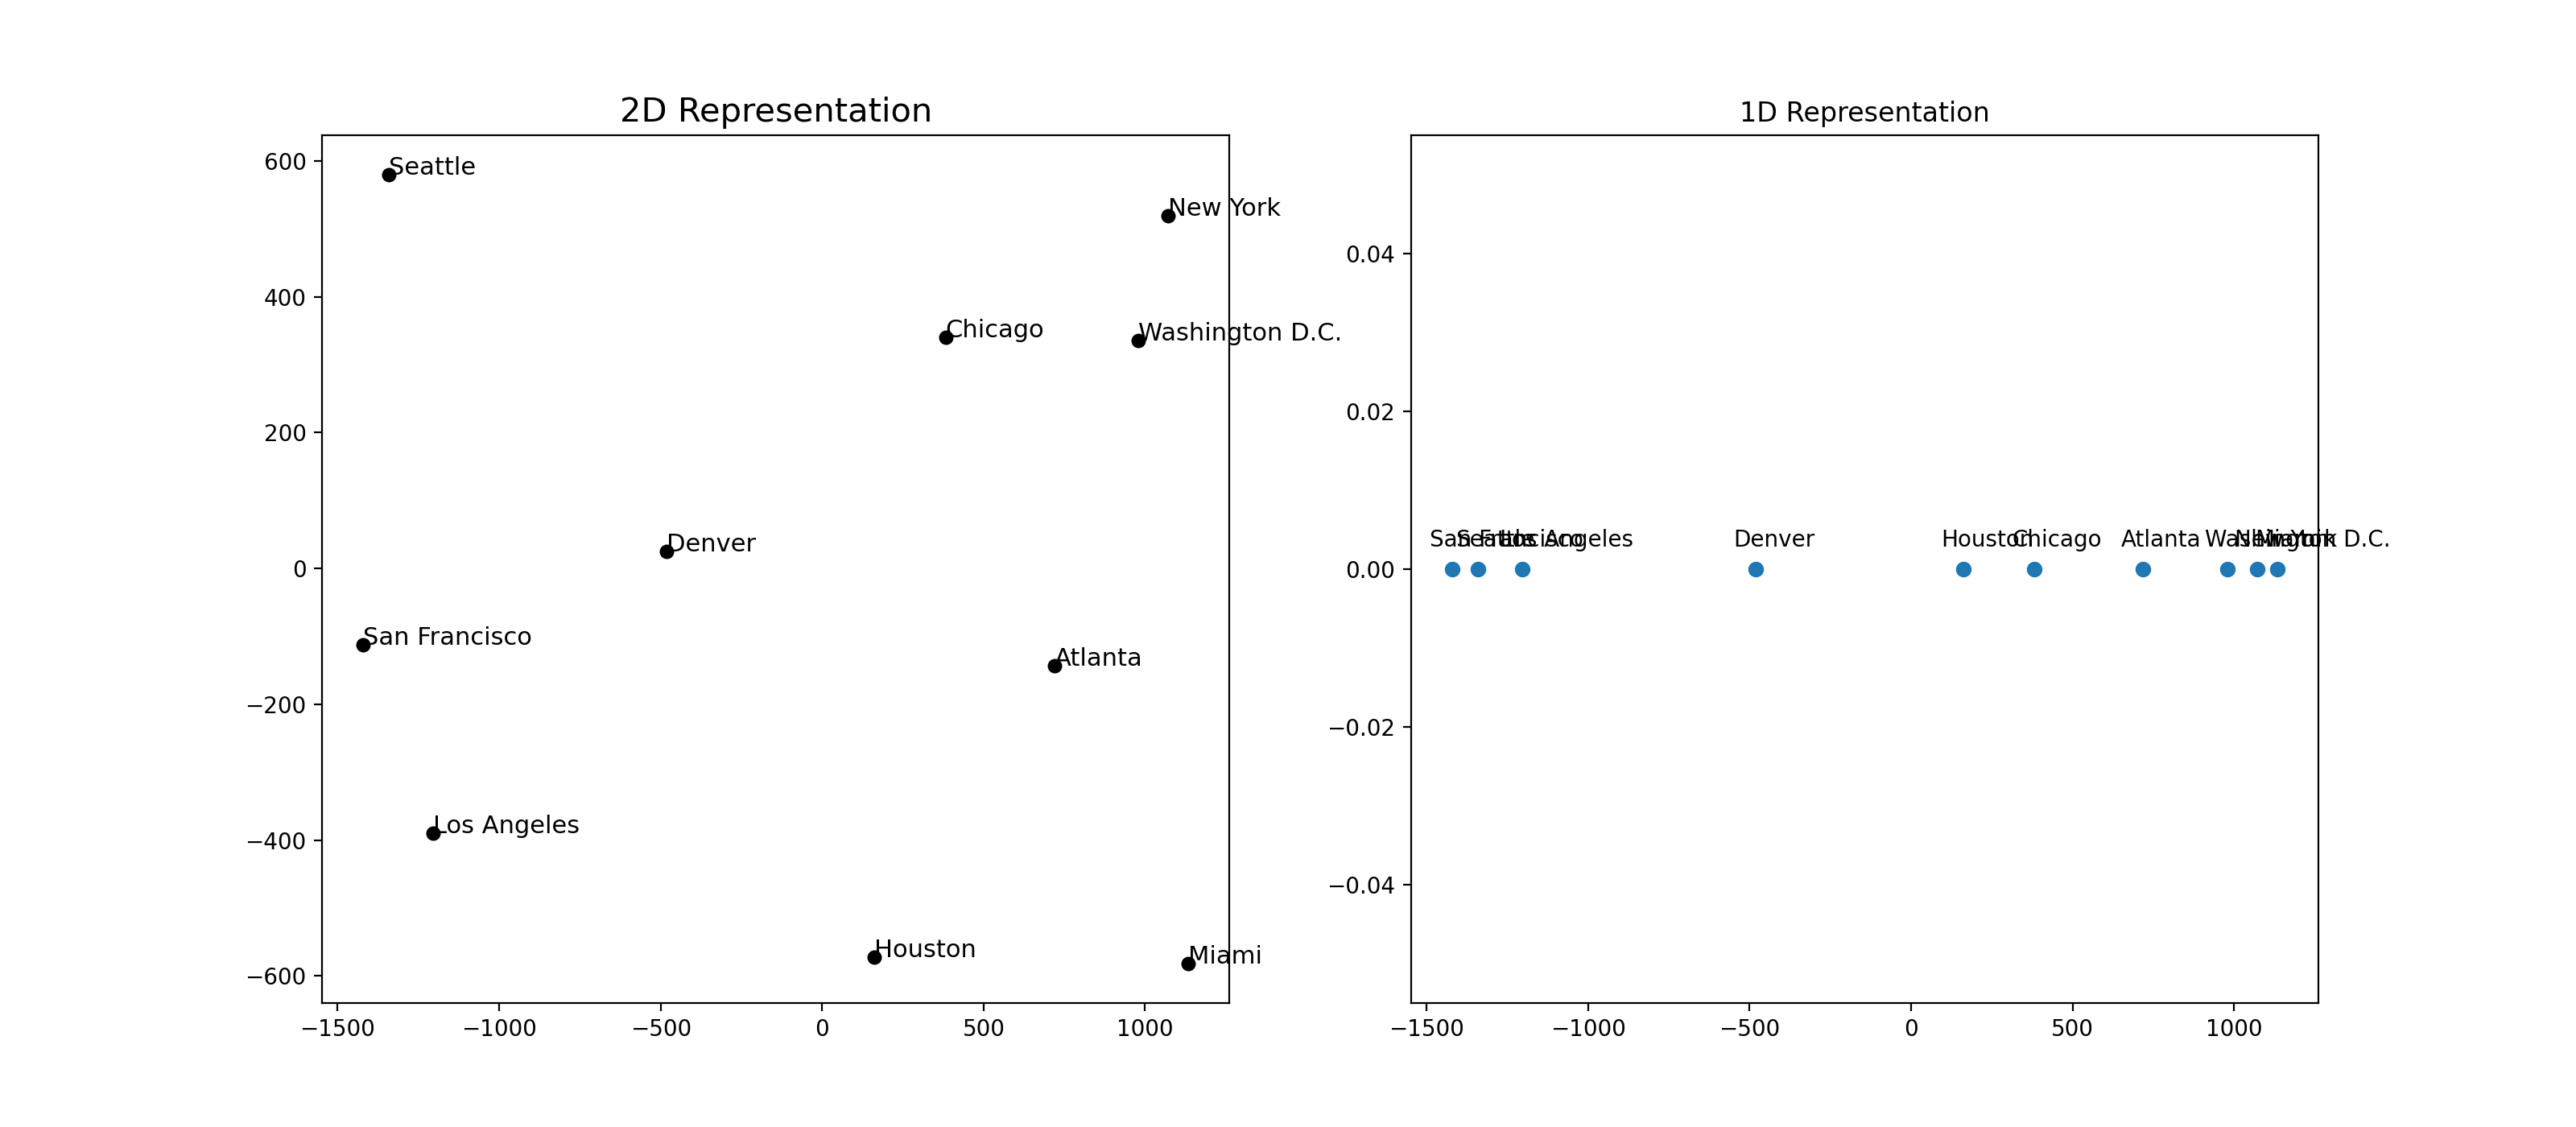

<function matplotlib.pyplot.show(block=None)>

In [8]:
# plot 2D figure
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(-Y[0], -Y[1], c='black', s=30)
plt.title('2D Representation', size=15)

# display the city names
for i in range(len(city)):
     plt.text(-Y[0][i]+0.02, -Y[1][i]+0.02, s=city[i], size=11)
    
# used for the y-axis
zeros = np.zeros(10)

# plot 1D figure
plt.subplot(1,2,2)

plt.scatter(-Y[0],zeros)
plt.title("1D Representation")

for label, x,y in zip(city, -Y[0], zeros):
    plt.annotate(
    label,
    xy = (x,y),
    xytext = [-10,10],
    textcoords = "offset points")
plt.show



### <span style="color:red">=========== End of Assignment 1 ===========</span>

## * Stress-based MDS

### <span style="color:red">============= Assignment 2 =============</span>

In [9]:
def loss_sammon(D, y):
    """
    Loss function (stress) - Sammon
    
    Parameters
    ----------
    D: (n,n) array. distance matrix in original space
        This is a symetric matrix
    y: (d,n) array
        d is the dimensionality of target space.
        n is the number of points.
        
    Returns
    -------
    stress: scalar. stress
    """
    
    n = y.shape[0]
    N = D.shape[0]
    
    # Fill zeros with 1s to avoid division by 0
    D = D + np.eye(N)     
    Dinv = 1 / D
   
    # find the euclidean distances of the target space
    d = euclidean_distances(y.T,y.T) + np.eye(N)
    
    delta = D-d
    
    # implement the sammon mathematical expression
    scale = 1/ D.sum()
    stress = ((delta**2)*Dinv).sum() 
    stress = scale* stress
    

    
    return stress

def grad_sammon(D, y):
    """
    Gradient function (first derivative) - Sammonn_dim
    
    Parameters
    ----------
    D: (n,n) array. distance matrix in original space
        This is a symetric matrix
    y: (d,n) array
        d is the dimensionality of target space.
        n is the number of points.
        
    Returns
    -------
    g: (k,n) array.
        Gradient matrix. 
        k is the dimensionality of target space.
        n is the number of points.
    """
    # dimensions
    d = y.shape[0]
    n = D.shape[0] 
    
    # euclidean distances of target space
    y_dist = euclidean_distances(y.T,y.T) 
    
    # sum of the elements above the k-th diagonal zeroed.
    delta = np.tril(D).sum()
    
    g = np.zeros((d,n))
    
    for k in range(n):
        inner_sum = np.zeros((1,d))
        for j in range(n):
            if k != j:
                # calculate the inner sum 
                inner_sum += ((y_dist[k][j] - D[k][j]) / D[k][j])*((y[:,k] - y[:,j])/ y_dist[k][j])
        g[:,k] = (2/delta) * inner_sum
    
    return g

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T

D = euclidean_distances(test_data.T, test_data.T)
y = np.array([[1,0],[1,1],[0,1],[0,0]]).T
loss = loss_sammon(D, y)
gradient = grad_sammon(D, y)

print(loss)
print(gradient)

0.6426937885631937
[[-0.0636803  -0.07372159  0.07975297  0.05764892]
 [ 0.06861392 -0.06258254 -0.07961112  0.07357973]]


### <span style="color:red">=========== End of Assignment 2 ===========</span>

The following function provided for students is used to do Assignment 3.

In [10]:
def stress_based_mds(x, n_dim, loss_f, grad_f, input_type='raw', 
                     lr=0.1, tol=1e-9, max_iter=6000):
    """
    Stress-based MDS
    
    Parameters
    ----------
    x: (d,n) array or (n,n) array
        If it is raw data -> (d,n) array
        otherwise, (n,n) array (distance matrix)
        n is the number of points
        d is the dimensionality of original space
    n_dim: dimensionality of target space
    loss_f: loss function
    grad_f: gradient function
    input_type: 'raw' or 'distance'
    init: initialisation method
        random: Initial y is set randomly
        fixed: Initial y is set by pre-defined values
    max_iter: maximum iteration of optimization
    
    Returns
    -------
    y: (n_dim,n) array. Embedded coordinates in target space
    losses: (max_iter,) History of stress
    """

    # obtain distance
    if input_type == 'raw':
        x_t = x.T
        D = euclidean_distances(x_t, x_t)
    elif input_type == 'distance':
        D = x
    else:
        raise ValueError('inappropriate input_type')
    
    # Remaining initialisation
    N = x.shape[1]

    np.random.seed(10)
    # Initialise y randomly
    y = np.random.normal(0.0,1.0,[n_dim,N])

    # calculate optimal solution (embedded coordinates)
    y, losses = gradient_descent(D, y, loss_f, grad_f, lr, tol, max_iter)
    
    return y, losses


### <span style="color:red">=========== Assignment 3 ===========</span>

<IPython.core.display.Javascript object>


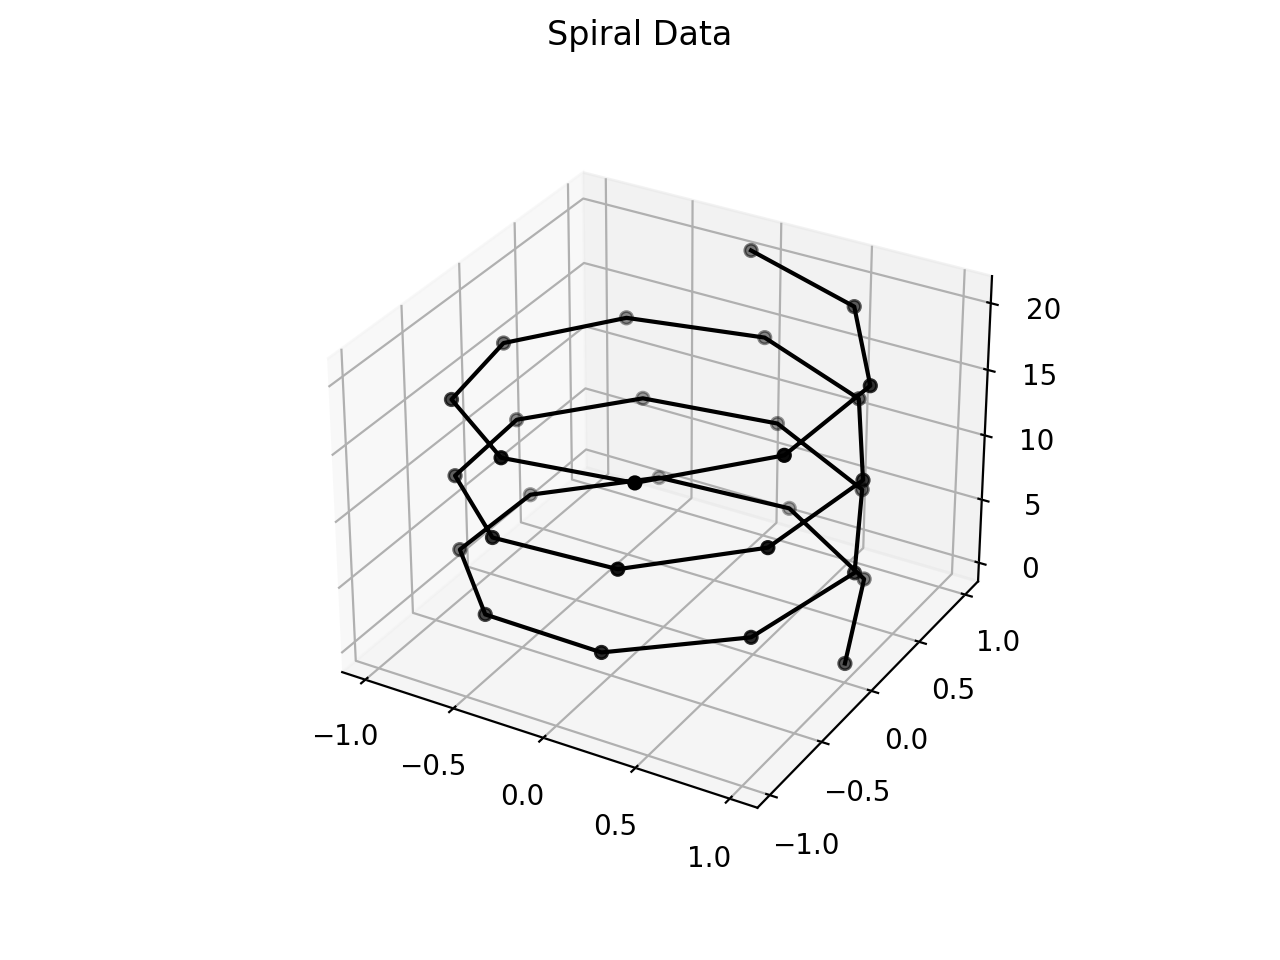

In [11]:
X_spiral = synthetic_spiral()

fig_spiral = plt.figure()
fig_spiral.suptitle('Spiral Data')

# Add 3d scatter plot
ax = fig_spiral.add_subplot(projection='3d')
ax.scatter(X_spiral[0,:], X_spiral[1,:], X_spiral[2,:], c='k')
ax.plot(X_spiral[0,:], X_spiral[1,:], X_spiral[2,:], c='k');

In [12]:
# apply stress_based_mds using different values of learning rate and tolerance
y, losses = stress_based_mds(X_spiral ,
                             n_dim =2,
                             loss_f =loss_sammon , 
                             grad_f = grad_sammon ,
                             input_type = "raw",
                             lr= 100,
                             tol = 0.001)
print(y)

iter: 5999, stress: 0.001023218258179765		

[[-5.63474168 -5.68790542 -5.74520937 -5.76042657 -5.67395948 -5.37770944
  -4.67656349 -3.73762717 -2.78186279 -1.86455231 -1.13654788 -0.88892842
  -0.98378495 -1.10725964 -0.9911988  -0.41450783  0.47114711  1.42697763
   2.37738104  3.20809998  3.63670982  3.67743318  3.52855726  3.46049017
   3.90393733  4.73611244  5.64341204  6.55434481  7.45065624  8.32726796]
 [-8.35365526 -7.47927793 -6.58547027 -5.67468956 -4.76148332 -3.90937487
  -3.41510677 -3.42473432 -3.52169839 -3.43594715 -2.97698559 -2.13762257
  -1.19205639 -0.24119269  0.65599182  1.27728417  1.45247421  1.3848129
   1.33839637  1.62038067  2.36530144  3.28477884  4.23389328  5.17220694
   5.90705425  6.25500622  6.39380559  6.42959565  6.42168425  6.41618276]]


<IPython.core.display.Javascript object>


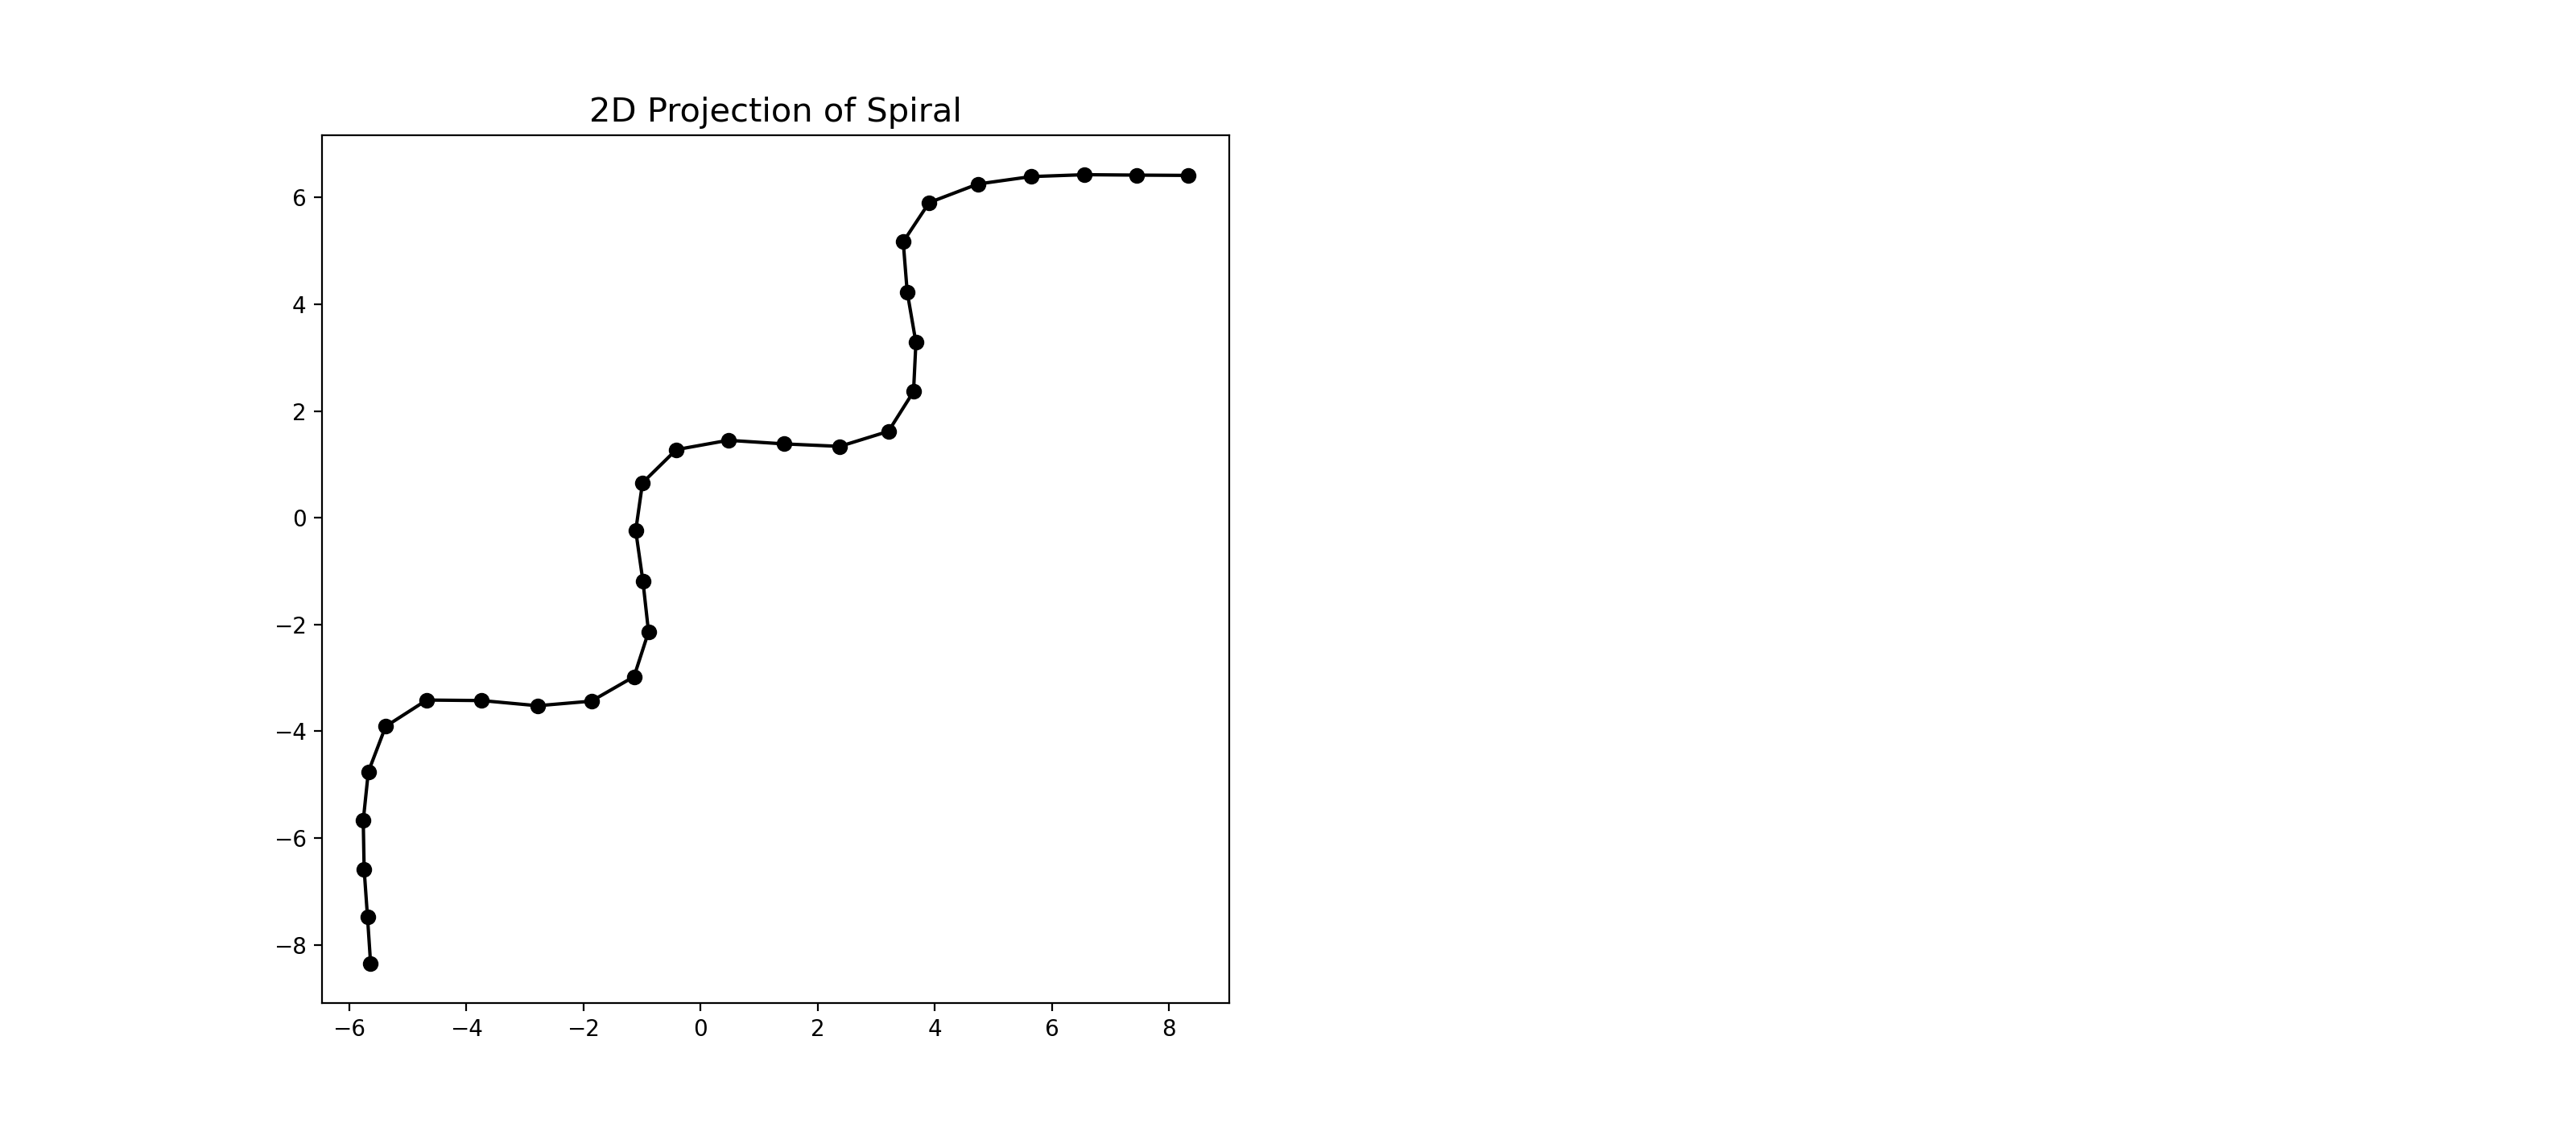

Text(0.5, 1.0, '2D Projection of Spiral')

In [13]:
# plot results
plt.figure(figsize=(16,7))
plt.subplot(1,2,1)
plt.scatter(y[0], y[1], c='k')
plt.plot(y[0], y[1], c='k')
plt.title('2D Projection of Spiral', size=15)


***Explain how you obtain two optimal hyperparameters with justification ***

I tried a number of different values for the learning rate and the tolerance in order to find the optimal values. I started experimenting with small values for the learning rate, such as 0.1, and the stress is 0.39, which is considerably high. When the learning rate increases, for instance to 10, the stress decreases and the value drops to 0.001264. The stress value is 0.001023, which is the ideal value since when I try to increase the learning rate more, the algorithm crashes with a stress value of 6.62658. For the tolerance, I experimented with 3 values: 0.1, 0.01,0.001 and 0.0001. After running the algorithm with the above values and the learning rate set to 100, the stress values are 0.09898,0.00945,0.001023, and 0.001023 respectively. Thus, the optimal values for the learning rate and tolerance are 100 and 0.001, respectively. This is also supported by the nicely shaped 2D spiral plot. 

### <span style="color:red">=========== End of Assignment 3 ===========</span>

## Part 2. Isometric Feature Mapping (ISOMAP)

In [14]:
from sklearn.metrics.pairwise import euclidean_distances
from Code.helpers import VIS_Shortest_path_2d, ImageViewer
from math import sqrt

### <span style="color:red">============= Assignment 4 =============</span>

In [15]:
import scipy
def fixed_radius_distance(X, epsilon):
    """
    Calculate epsilon-NN
    
    Parameters
    ----------
    X: (d,n) array, where n is the number of points and d is its dimension
    epsilon: criterion of selecting neighbors
        Select points as its neighbours if distance < epsilon
        
    Returns
    -------
    nbrs_dist: (n,k*) array
        It is filled with distances with neighbors. 
        In each row, k* varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    nbrs_idx: (n,k*) array
        It is filled with the indices of neighbors. 
        In each row, k* varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    """
    # compute euclidean distances
    eu_distances = euclidean_distances(X.T,X.T)
    n = X.shape[0]
    d = X.shape[1]
    
    
    nbrs_dist = [] # neighbours distances
    nbrs_idx = [] # neighbours indexes
    
    
    for i in range(len(eu_distances)):
        # temporary empty lists 
        nbrs_temp_dist = list()
        nbrs_temp_idx = list()
       
        for j in range(len(eu_distances[i])):   
            if (i == j):
                pass
            else:
        # If the calculated distance is inside the ε-radius      
                if (eu_distances[i][j] < epsilon):   
                    # add it to the neighbors distances
                    nbrs_temp_dist.append(eu_distances[i][j])
                    nbrs_temp_idx.append(j)
        # convert temporary lists to 1d np arrays
        nbrs_temp_dist = np.array(nbrs_temp_dist)
        nbrs_temp_idx = np.array(nbrs_temp_idx)
        
        # append the temp ones to the main lists
        nbrs_dist.append(nbrs_temp_dist)
        nbrs_idx.append(nbrs_temp_idx)
   
    # convert main lists to np arrays
    nbrs_dist = np.array(nbrs_dist, dtype =object)
    nbrs_idx = np.array(nbrs_idx, dtype = object)
    
    return nbrs_dist,nbrs_idx

def nearest_neighbor_distance(X, n_neighbors):
    """
    Calculate K-NN
    
    Parameters
    ----------
    X: (d,n) array, where n is the number of points and d is its dimension
    n_neighbors: number of neighbors
        Select n_neighbors(k) nearest neighbors

    Returns
    -------
    dist: (n,k) array
        It is filled with distances with neighbors. 
        In each row, k varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    nbrs: (n,k) array
        It is filled with the indices of neighbors. 
        In each row, k varies according to the number of neighbours
        Each row corresponds to a specific point (row-major order)
    """
    d = X.shape[1]
    
    # compute euclidean distances of points in X
    eu_distances = euclidean_distances(X.T,X.T)
    
    # create temporary lists of neighbor distances and indexes
    nbrs_temp_dist = list()
    nbrs_temp_idx = list()
    
    # create main lists
    nbrs_dist = list()
    nbrs_idx = list()
    
    for i in range(len(eu_distances)):
        nbrs_temp_dist.append([])
        nbrs_temp_idx.append([])
        for j in range(len(eu_distances[i])): 
            # if distance is not 0 i.e the distance of a point from itself
            if (i != j):  
               # add it to the neighbors distances
                nbrs_temp_dist[i].append(eu_distances[i][j])
                nbrs_temp_idx[i].append(j)
                
    
    
    for i in range(len(nbrs_temp_idx)):
        # find the index
        idx = np.array(nbrs_temp_dist[i]).argsort()[::1]
        indexes = np.array(nbrs_temp_idx[i])[idx]
        distances = np.array(nbrs_temp_dist[i])[idx]
        
        # append distances and indexes to the main lists
        nbrs_dist.append(distances[:n_neighbors])
        nbrs_idx.append(indexes[:n_neighbors])
     
    # convert the main lists to np arrays
    nbrs_dist = np.array(nbrs_dist)
    nbrs_idx = np.array(nbrs_idx)

        

    # return the neighbors list and their index
    return nbrs_dist,nbrs_idx


# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T

dist, idx = fixed_radius_distance(test_data, 9.1)
print(dist)
print(idx)

dist, idx = nearest_neighbor_distance(test_data, 2)
print(dist)
print(idx)

[array([3.16227766, 9.        , 2.44948974])
 array([3.16227766, 4.47213595]) array([9., 9.])
 array([2.44948974, 4.47213595, 9.        ])]
[array([1, 2, 3]) array([0, 3]) array([0, 3]) array([0, 1, 2])]
[[2.44948974 3.16227766]
 [3.16227766 4.47213595]
 [9.         9.        ]
 [2.44948974 4.47213595]]
[[3 1]
 [0 3]
 [0 3]
 [0 1]]


In [16]:
def isomap(x, n_components, n_neighbors=None, epsilon=None, dist_func=None, cmds_func=None):
    """
    ISOMAP
    
    Parameters
    ----------
    x: (d,n) array, where n is the number of points and n is its dimensionality.
    n_components: dimentionality of target space
    n_neighbors: the number of neighourhood
    epsilon: fixed radius
    dist_func: function for calculating distance matrix
    
    Returns
    -------
    Y: (d,n) array. Embedded coordinates from cmds in Step 3.
    dist_mat: (n,n)array. Distance matrix made in Step 1.
    predecessors: predecessors from "shortest_path" function in Step 2.
    """
    assert(cmds_func is not None)
    assert((epsilon is not None) or (n_neighbors is not None))

    n_points = x.shape[1]
   
    
    # Step 1.
    # find nearest neighbors to each sample with the given condition
    
    # create the distance np-array
    dist_mat = np.zeros((n_points, n_points))
    
    # checked which distance function is passed as an argument
    if epsilon is not None:        
        distances, indexes = dist_func(x, epsilon)
    else:
        distances, indexes = nearest_neighbor_distance(x, n_neighbors)
    
    # populate the distance matrix based on the indexes 
    for i in range(len(indexes)):
        for j in range(len(indexes[i])):
            index_x = i
            index_y = indexes[i][j]
            dist_mat[index_x][index_y] = distances[i][j]
            
            
    # Step 2.
    # Find shortest paths
    
    from scipy.sparse import csr_matrix
    from scipy.sparse.csgraph import shortest_path
    
    
    # Get the compressed sparse matrix of the distance-matrix
    graph = csr_matrix(dist_mat)
    
    # Perform shortest-path graph search 
    distance_matrix, predecessors = shortest_path(csgraph=graph, return_predecessors=True, directed=False)
    

     # Step 3.
     # Apply cMDS
    
    Y, evals, evecs = cmds(distance_matrix, n_components , input_type = "distance")


    return  Y,dist_mat,predecessors 

# The following code to be used for testing student's implementation during marking. Don't change or your mark will be deducted!
test_data = np.array([[0,3,2], [1,3,5], [-6,-3,5], [1,1,1]]).T
n_components = 2
n_neighbors = 2
Y_nn, dist_nn, predecessors_nn = isomap(test_data, 
                                            n_components, 
                                            n_neighbors=n_neighbors, 
                                            dist_func=nearest_neighbor_distance, 
                                            cmds_func=cmds)
print(Y_nn)
print(dist_nn)
print(predecessors_nn)

[[-1.53779536 -4.68615915  7.46351727 -1.23956276]
 [ 0.54291307  0.95571131  0.39708534 -1.89570972]]
[[0.         3.16227766 0.         2.44948974]
 [3.16227766 0.         0.         4.47213595]
 [9.         0.         0.         9.        ]
 [2.44948974 4.47213595 0.         0.        ]]
[[-9999     0     0     0]
 [    1 -9999     0     1]
 [    2     0 -9999     2]
 [    3     3     3 -9999]]


### Example with Swiss Roll

In [17]:
from sklearn.datasets import make_swiss_roll

n_points = 1000
data_s_roll, color = make_swiss_roll(n_points)
data_s_roll = data_s_roll.T
data_s_roll

array([[ 3.72494645,  1.97137659,  0.1928687 , ...,  2.87447838,
         5.9551358 , 12.0424473 ],
       [20.84317018,  2.62355273, 10.85116441, ..., 17.97241221,
         1.72990728,  2.38117263],
       [-3.99576461,  7.33084032,  7.82696913, ...,  6.88216077,
         3.24570889,  4.73875468]])

<IPython.core.display.Javascript object>


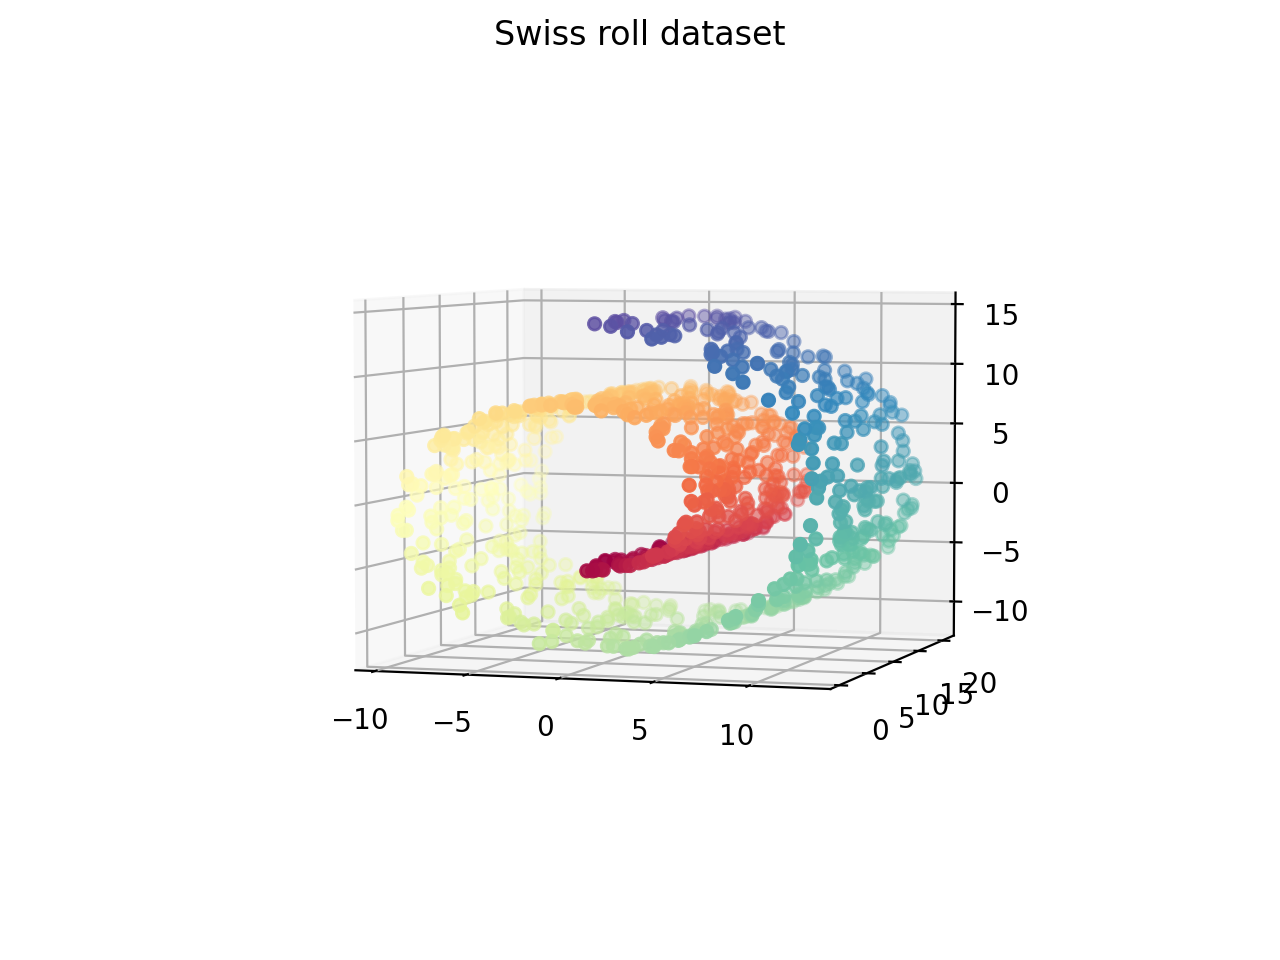

In [18]:
fig_swiss_roll = plt.figure()
fig_swiss_roll.suptitle("Swiss roll dataset")

# Add 3d scatter plot
ax = fig_swiss_roll.add_subplot(projection='3d')
ax.scatter(data_s_roll[0,:], data_s_roll[1,:], data_s_roll[2,:], c=color, 
           cmap=plt.cm.Spectral)
ax.view_init(4, -72);

<IPython.core.display.Javascript object>


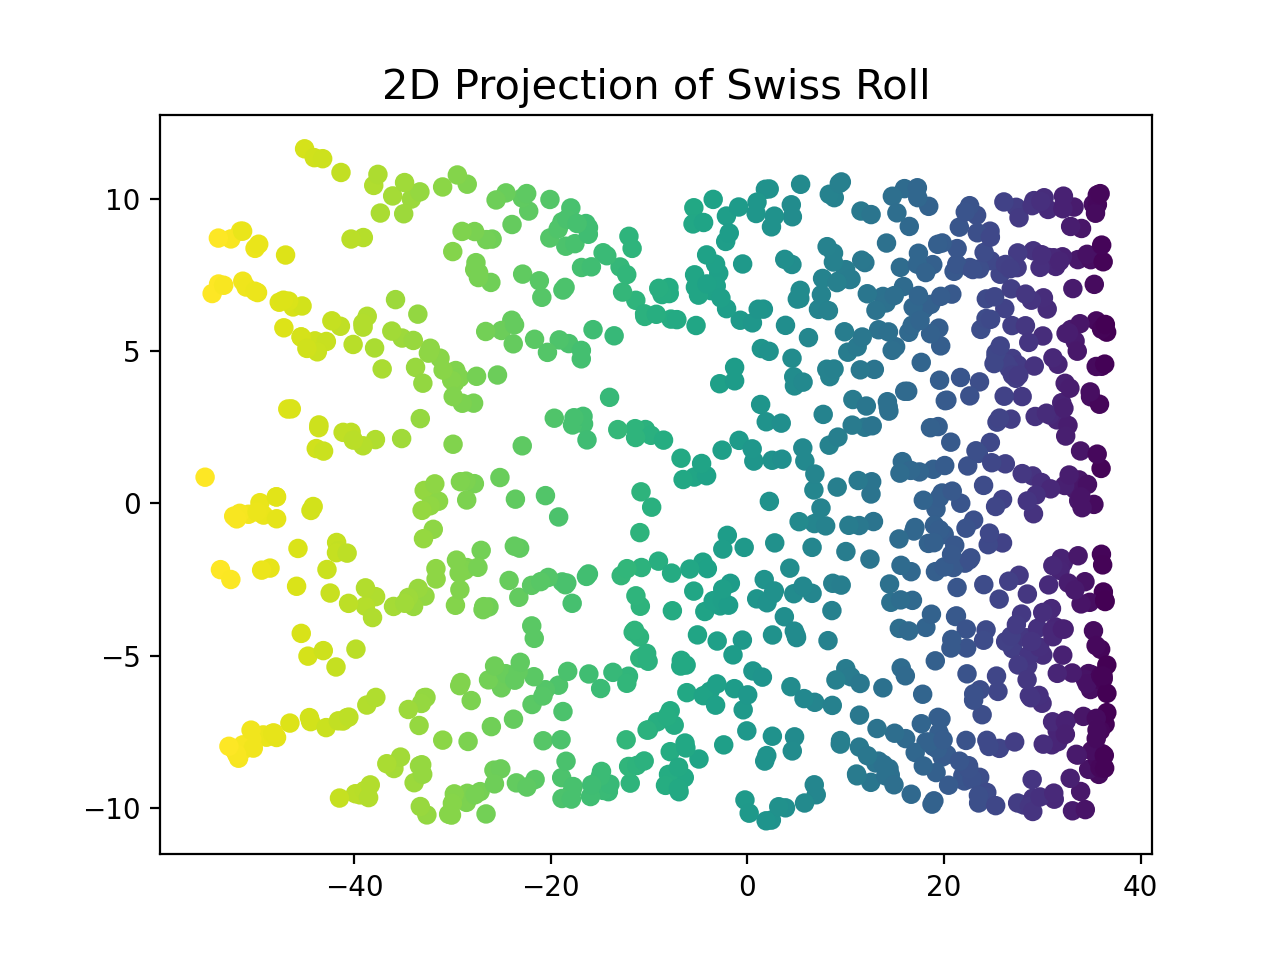

Text(0.5, 1.0, '2D Projection of Swiss Roll')

In [19]:
n_components = 2
# Apply Isomap function on the swiss roll dataset using fixed_radius_distance
Y_nn, dist_nn, predecessors_nn = isomap(data_s_roll,
                                        n_components,
                                        n_neighbors=6, 
                                        epsilon = 3.5,
                                        dist_func= fixed_radius_distance,
                                        cmds_func=cmds )

# Visualize the 2D projection of the swiss roll dataset using isomap
plt.figure()
plt.scatter(Y_nn[0], Y_nn[1], c = color)

plt.title('2D Projection of Swiss Roll', size=15)

<IPython.core.display.Javascript object>


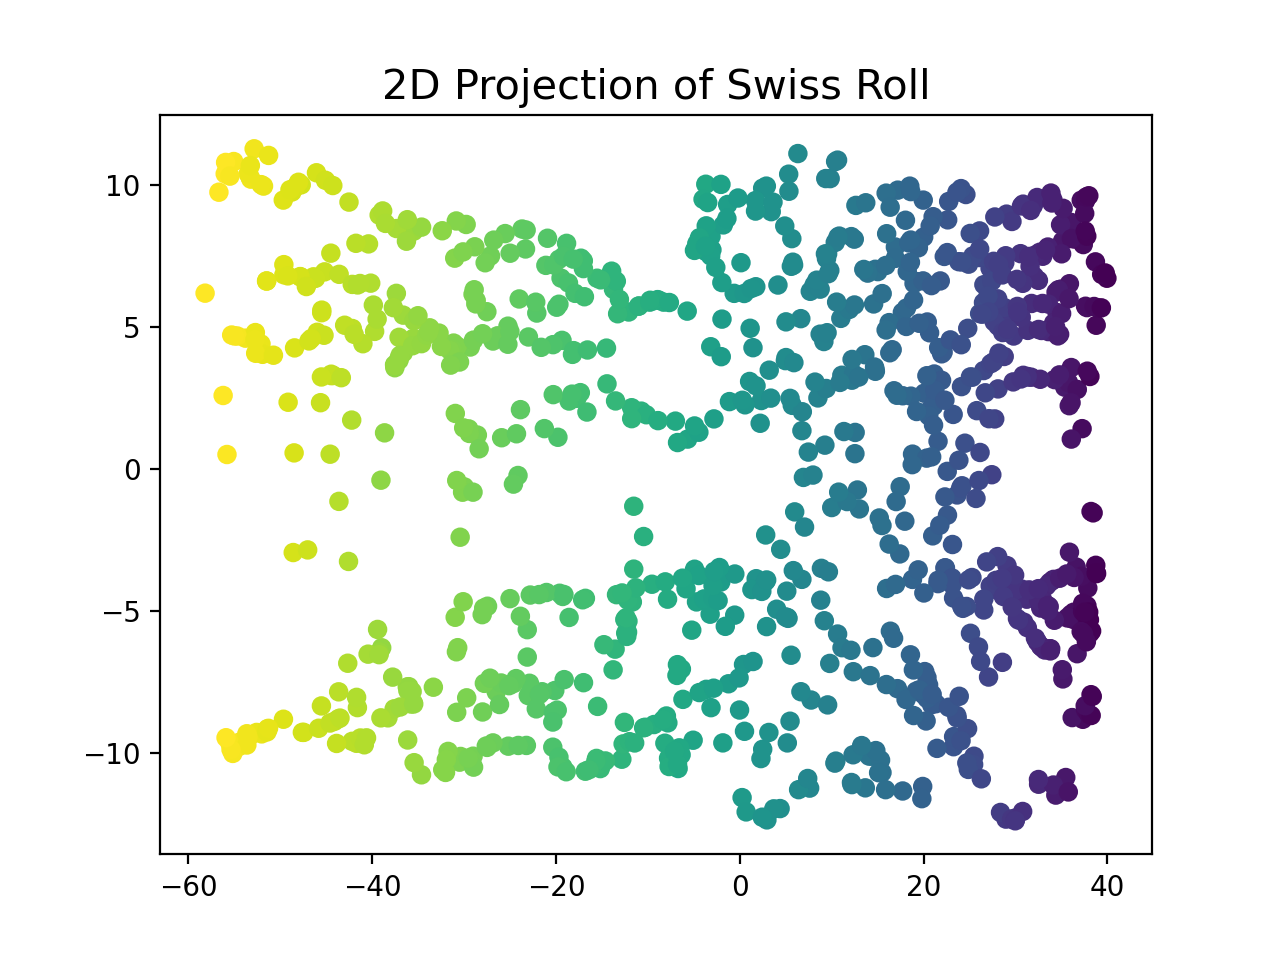

Text(0.5, 1.0, '2D Projection of Swiss Roll')

In [20]:
n_components = 2
# Apply Isomap function on the swiss roll dataset using knn
Y_nn, dist_nn, predecessors_nn = isomap(data_s_roll,
                                        n_components,
                                        n_neighbors=6, 
                                        dist_func= nearest_neighbor_distance,
                                        cmds_func=cmds )

# Visualize the 2D projection of the swiss roll dataset using isomap
plt.figure()
plt.scatter(Y_nn[0], Y_nn[1], c = color)

plt.title('2D Projection of Swiss Roll', size=15)

### <span style="color:red">=========== End of Assignment 4 ===========</span>
    
    
The following code is provided to do Assignment 5.
    

### Example with face data

In [21]:
from Code.dataset import face_tenenbaum

data_face = face_tenenbaum()
print(data_face.shape)
image_size = [64,64]

(4096, 698)


In [22]:
n_components = 2
n_neighbors = 6

# Apply isomap function on face dataset using knn
Y_face, dist_face, predecessors_face = isomap(data_face, n_components, 
                                              n_neighbors=n_neighbors, 
                                              dist_func=nearest_neighbor_distance, 
                                              cmds_func=cmds)
print(Y_face)
print(dist_face)
print(predecessors_face)

[[-26.16906241  32.54056096 -22.20834247 ...  62.64337861  25.3725232
  -21.12164027]
 [  0.5788533   12.85688329  -6.49029187 ...   9.50477199  18.85309005
    3.41350526]]
[[0.         0.         6.74323967 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [6.74323967 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[[-9999   512     0 ...   193   448    46]
 [    2 -9999    84 ...   193   431   507]
 [    2   512 -9999 ...   193   431    46]
 ...
 [  504   646   265 ... -9999   386   507]
 [  504   512    84 ...   137 -9999   507]
 [   45   512    45 ...   193   448 -9999]]


### <span style="color:red">============= Assignment 5 =============</span>

#### Shortest path of specific two points

In [23]:
def get_shortest_path(predecessors, start_idx, end_idx):
    path = [end_idx]
    k = end_idx
    while predecessors[start_idx, k] != -9999:
        path.append(predecessors[start_idx, k])
        k = predecessors[start_idx, k]
    return path[::-1]

#### Path 1

<IPython.core.display.Javascript object>


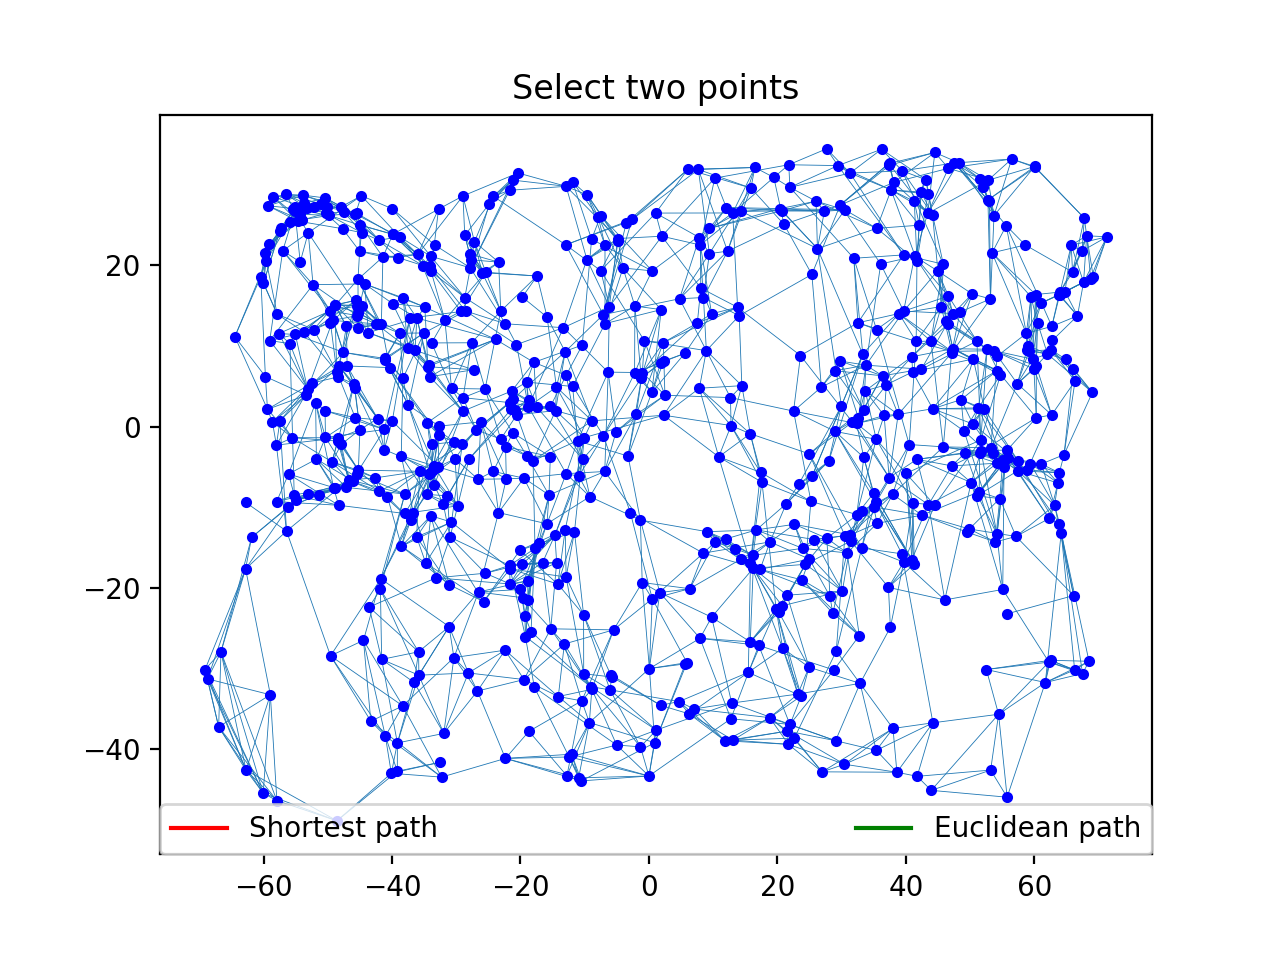

In [24]:
fig_face_index_h = plt.figure()
vis_face_index_h = VIS_Shortest_path_2d(Y_face, dist_face, predecessors_face, 
                                        fig_face_index_h)

Index of point 1 : 100
Index of point 2 : 170
Index of point 3 : 103
Index of point 4 : 674
Index of point 5 : 400
Index of point 6 : 625
Index of point 7 : 194
Index of point 8 : 444
Index of point 9 : 682
Index of point 10 : 687


<IPython.core.display.Javascript object>


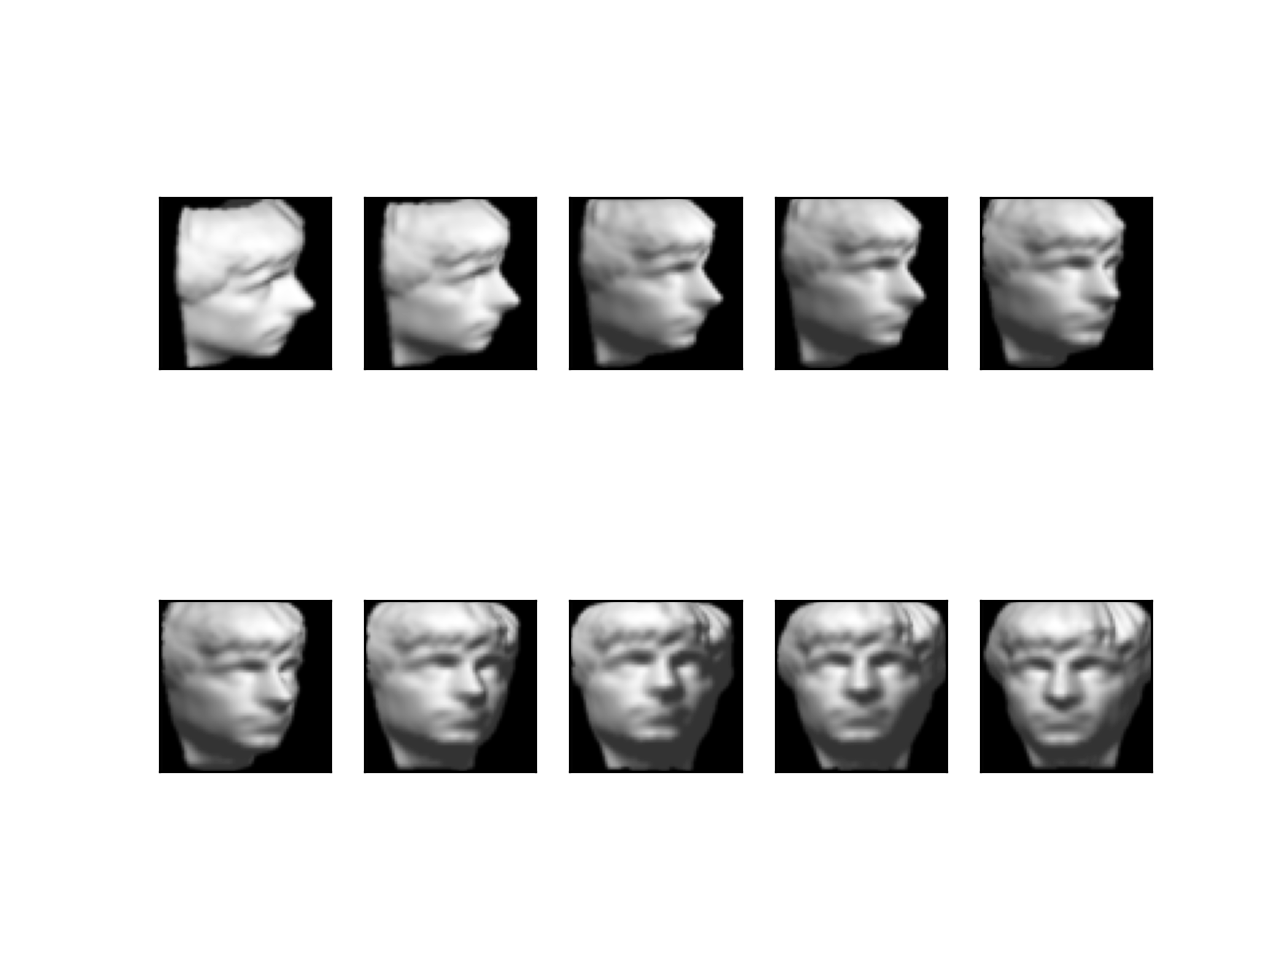

In [25]:
image_size = [64,64]
start_idx = 100
end_idx = 687

# find the shortest path between the two indexes
path = get_shortest_path(predecessors_face,start_idx,end_idx)

# find indexes of points used in the path
for i in range(len(path)):
    print("Index of point",i+1,":",path[i])

# visualize the path
fig = plt.figure()
img_viewer = ImageViewer(data_face, path,image_size, fig, max_row=5)
img_viewer.show()

#### Path 2

<IPython.core.display.Javascript object>


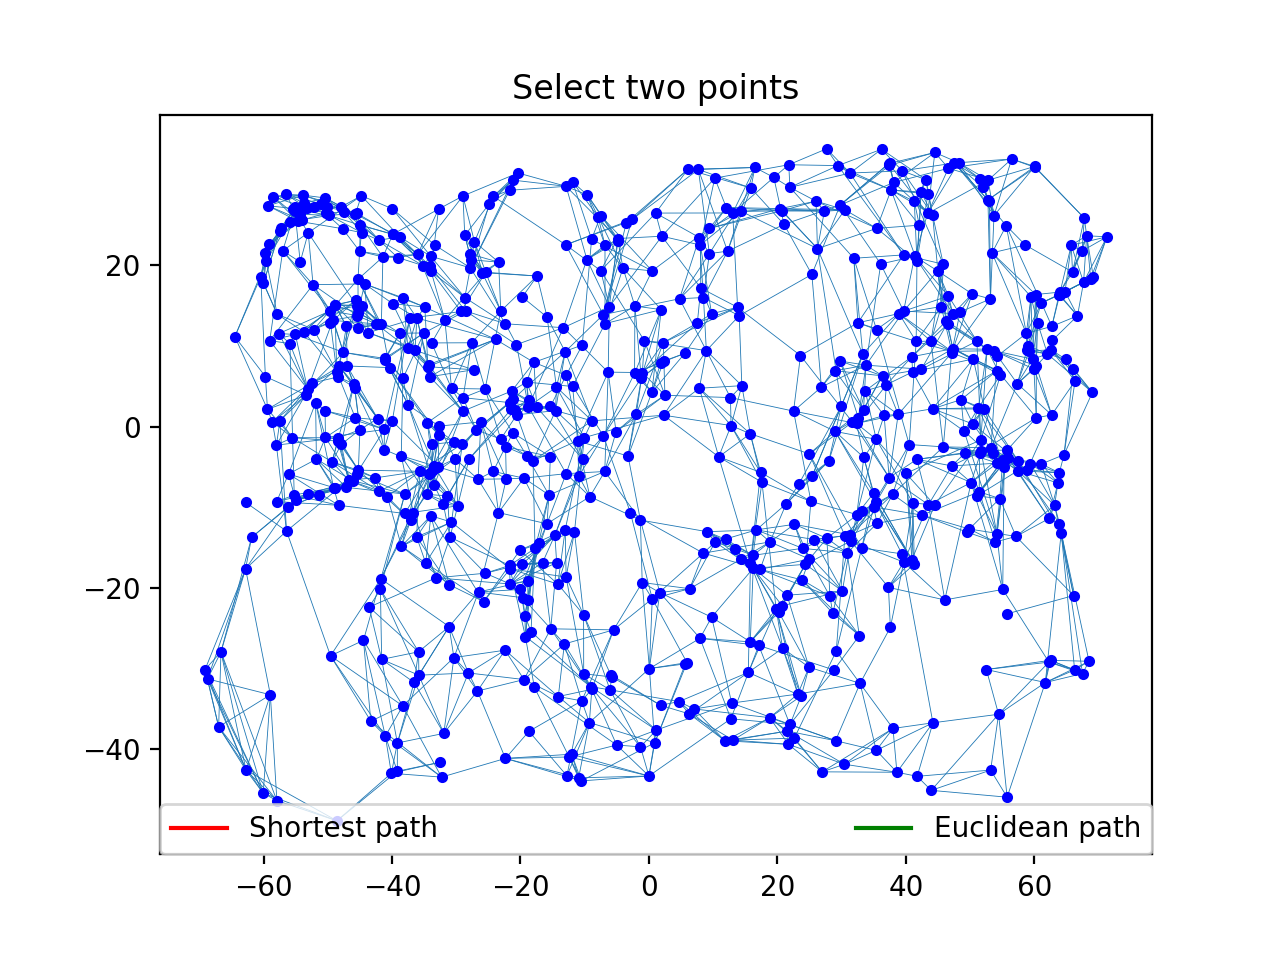

In [26]:
fig_face_index_v = plt.figure()
vis_face_index_v = VIS_Shortest_path_2d(Y_face, dist_face, predecessors_face, 
                                        fig_face_index_v)

Index of point 1 : 72
Index of point 2 : 15
Index of point 3 : 237
Index of point 4 : 659
Index of point 5 : 647
Index of point 6 : 149
Index of point 7 : 2
Index of point 8 : 265
Index of point 9 : 600
Index of point 10 : 79
Index of point 11 : 82
Index of point 12 : 363
Index of point 13 : 126
Index of point 14 : 30
Index of point 15 : 342
Index of point 16 : 380
Index of point 17 : 280
Index of point 18 : 454
Index of point 19 : 124


<IPython.core.display.Javascript object>


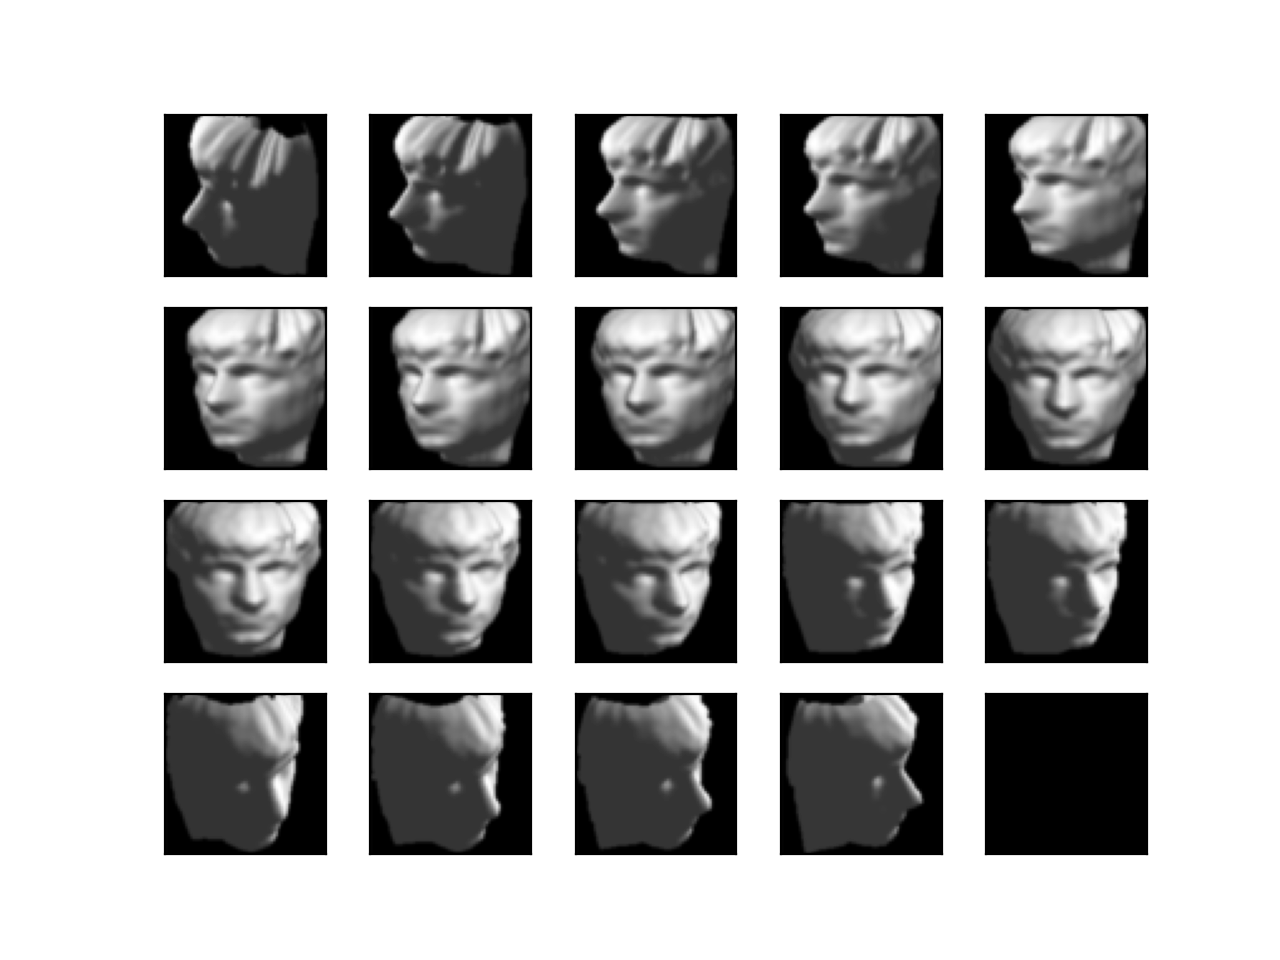

In [27]:
# Path 2 
image_size = [64,64]
start_idx = 72
end_idx = 124

# find the shortest path between the two indexes
path = get_shortest_path(predecessors_face,start_idx,end_idx)


# find indexes of points used in the path
for i in range(len(path)):
    print("Index of point",i+1,":",path[i])
    
# visualize the path
fig = plt.figure()
img_viewer = ImageViewer(data_face, path,image_size, fig, max_row=5)
img_viewer.show()

**Explain what you observe on those points in two paths in terms of manifold learning**

As can be viewed by the above plots, the direction and pose vary gradually and smoothly. For example, in the first path the face starts by looking to the right and gradually tilts towards the center. That means that Isomap which is a non-linear method seems to be able to capture the variations in the face movements and thus present low dimensional manifolds of the high-dimensional data accurately. 


### <span style="color:red">=========== End of Assignment 5 ===========</span>



## Part 3. Locally Linear Embedding (LLE) 

In [28]:
from scipy.stats import pearsonr, spearmanr
from Code.helpers import VIS_Bars
from Code.lle import lle

### <span style="color:red">============ Assignment 6 =========== </span>

In [29]:
from sklearn.datasets import make_s_curve
n_points = 1000
X, angle = make_s_curve(n_points, random_state=0)
X = X.T

<IPython.core.display.Javascript object>


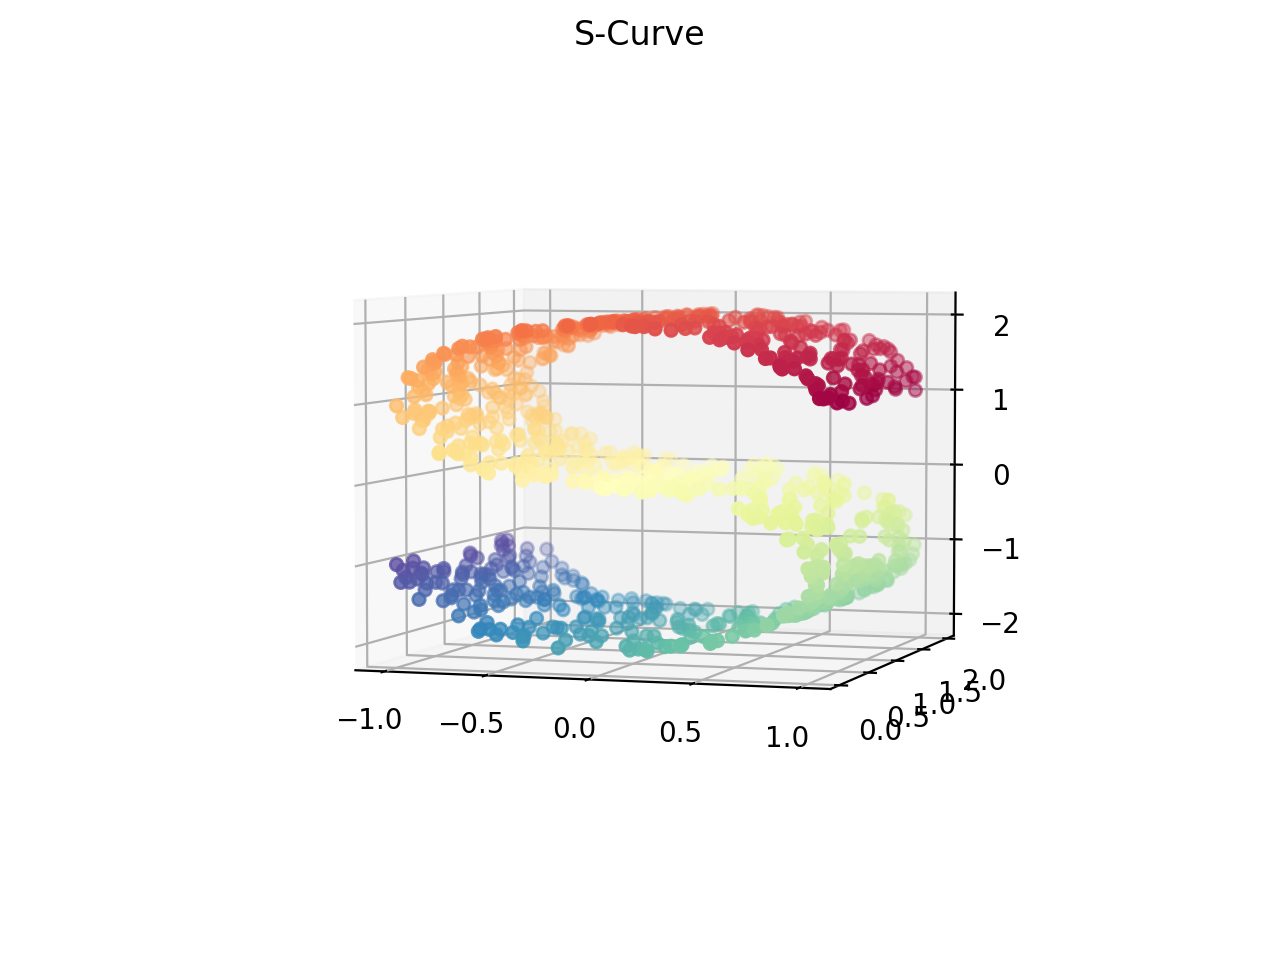

In [30]:
fig_s_curve = plt.figure()
fig_s_curve.suptitle('S-Curve')
    
colorize = dict(c=angle, cmap=plt.cm.Spectral)

# Add 3d scatter plot
ax = fig_s_curve.add_subplot(projection='3d')
ax.scatter(X[0,:], X[1,:], X[2,:], **colorize)
ax.view_init(4, -72)

In [31]:
import statistics
import scipy.stats
n_dim = 2


# list to store pearson coefficients
pearson_coef = []

for k in range(5,51):
    
    # apply lle using knn to s_curve dataset
    Y_s_curve = lle(X ,
            n_components =n_dim,
            n_neighbors =k,
            dist_func = nearest_neighbor_distance,
            reg_func =None)
    
    # x-coordinates
    x = Y_s_curve[0]
    # y-coordinates
    y = Y_s_curve[1]
    
    # r is the pearson's coefficient and p the the p-value
    r,p = scipy.stats.pearsonr(x, y)
    pearson_coef.append(r)

# find the best k value based on the index of the maximum pearson coefficient
opt_k = pearson_coef.index(max(pearson_coef)) + 5
print("Optimal k-nearest neighbors",opt_k)

# apply lle using optimal value of k to s_curve dataset
Y_s_curve = lle(X ,
            n_components =n_dim,
            n_neighbors =opt_k,
            dist_func = nearest_neighbor_distance,
            reg_func =None)

Optimal k-nearest neighbors 34


<IPython.core.display.Javascript object>


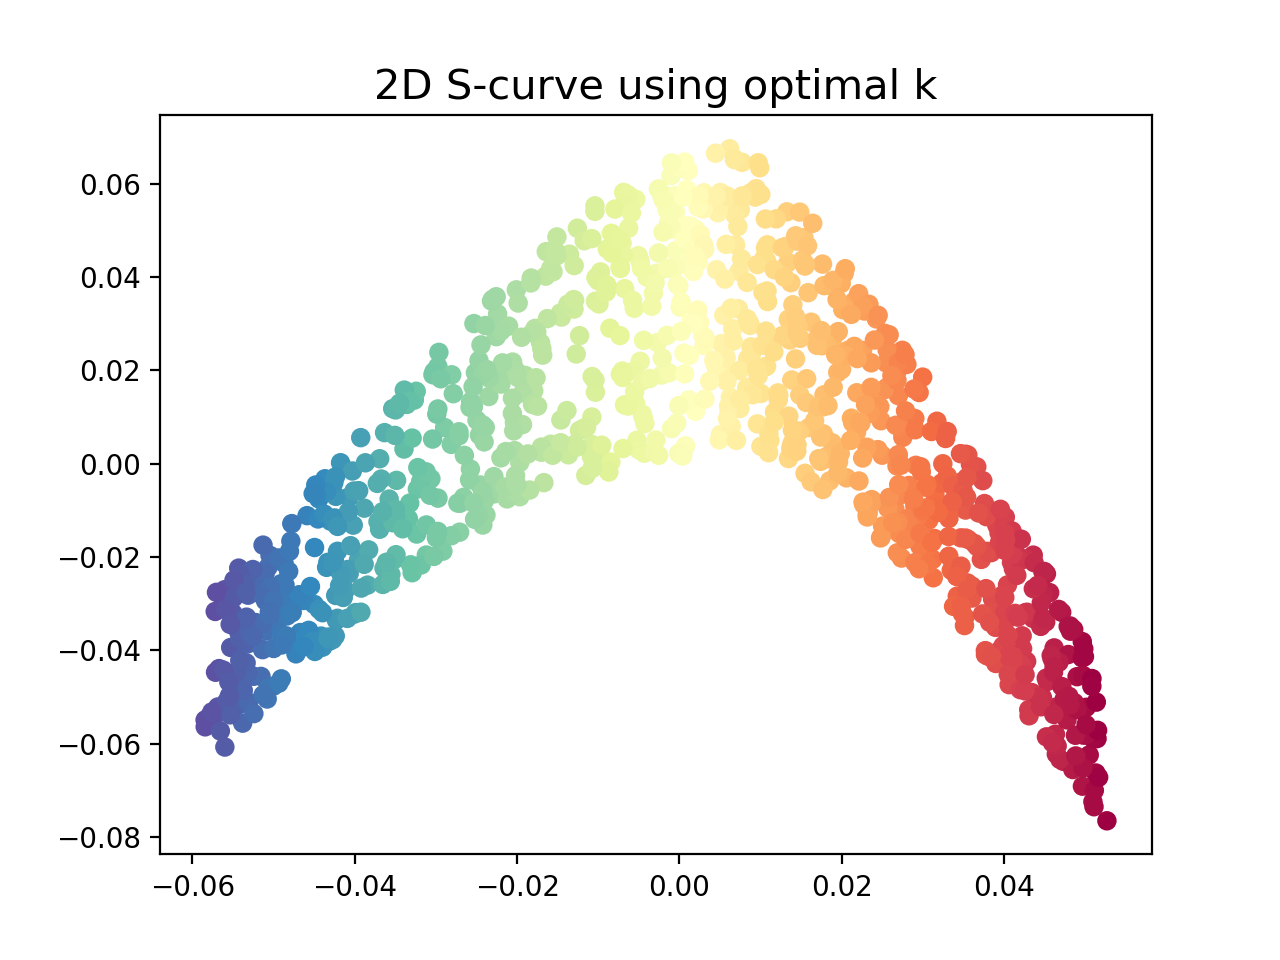

Text(0.5, 1.0, '2D S-curve using optimal k')

In [32]:
# Visualize the 2D S-curve using the optimal value of k
plt.figure()

plt.scatter(Y_s_curve[0], Y_s_curve[1], **colorize)

plt.title('2D S-curve using optimal k', size=15)

In [33]:
n_dim = 2


# initialize empty list to store pearson coefficient 
pearson_coef = []

# initialize a high value for the best pearson value (we want to minimize)
r_best = 1000
# initialize the best epsilon value
e_best = 0
# loop thourgh epsilon values from 0.1 to 0.8
for e in np.arange(0.1,0.9,0.1):
    # catch the exceptions where the epsilon value is too small to fit
    try:
        # apply lle using fixed_radius_distance to s_curve dataset
        Y_s_curve = lle(X ,
                n_components =n_dim,
                epsilon = e,
                dist_func = fixed_radius_distance,
                reg_func =None)
        # x-coordinates
        x = Y_s_curve[0]
        # y-coordinates
        y = Y_s_curve[1]
        # r is the pearson's coefficient and p the the p-value
        r,p = scipy.stats.pearsonr(x, y)
        # find the absolute value of r
        r_abs = abs(r)
        
        # find the smallest value of r
        if r_abs < 1:
            # store the best pearson coefficient value
            r_best = r_abs
            # store the best epsilon value
            e_best = e
       
        
    except:
        print("e exception",e)

print("Optimal epsilon value",e_best)

# Apply lle to s_curve dataset using optimal value of epsilon
Y_s_curve = lle(X ,
            n_components =n_dim,
            epsilon = e_best,
            dist_func = fixed_radius_distance,
            reg_func =None)

e exception 0.1
e exception 0.2
Optimal epsilon value 0.8


<IPython.core.display.Javascript object>


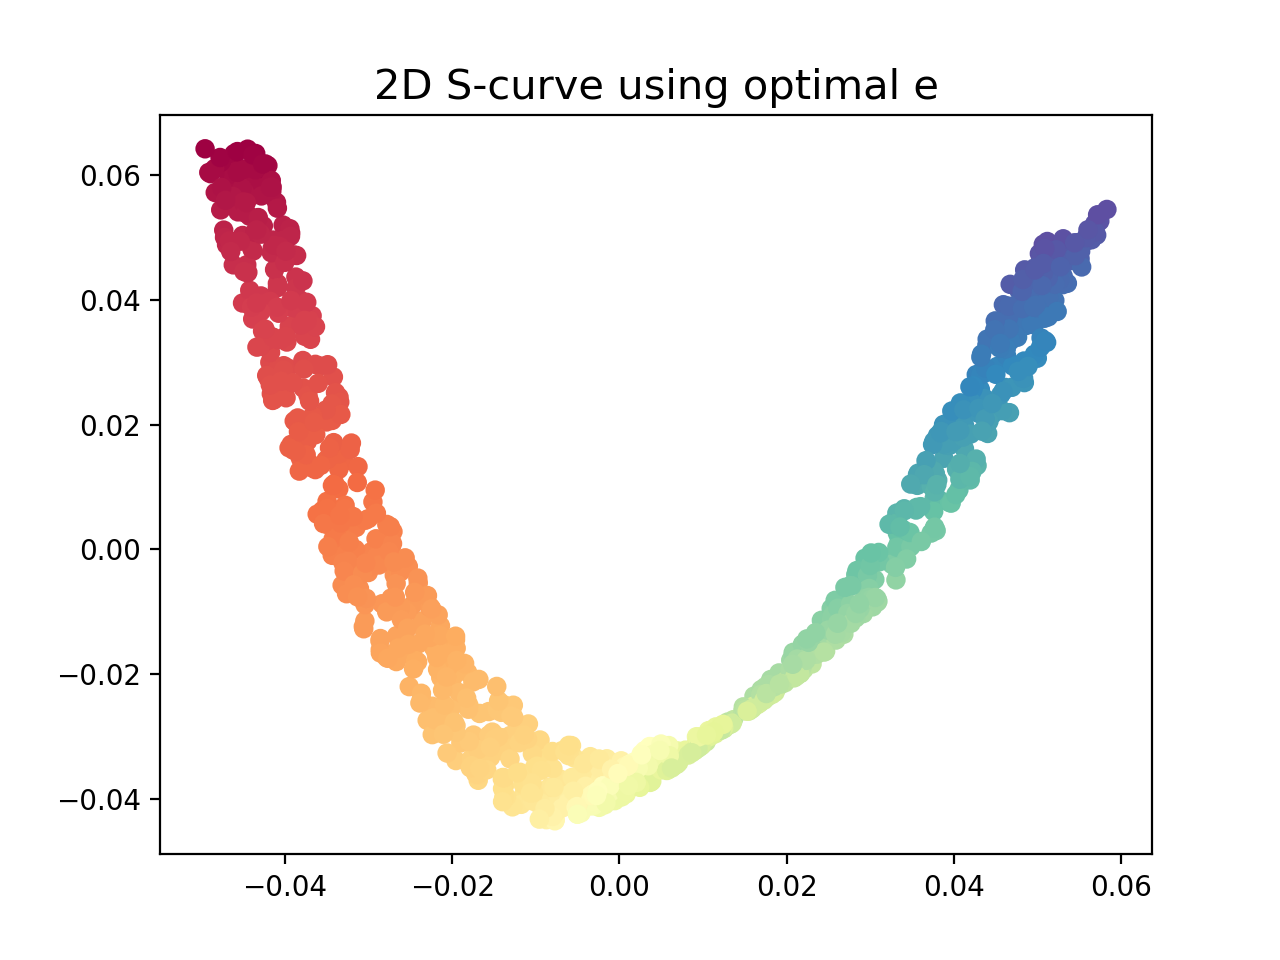

Text(0.5, 1.0, '2D S-curve using optimal e')

In [34]:
# Visualize the 2D projection of S-curve using the optimal value of epsilon
plt.figure()

plt.scatter(Y_s_curve[0], Y_s_curve[1], **colorize)

plt.title('2D S-curve using optimal e', size=15)

**Describe a criterion that works effectively in finding out the optimal hyperparameters, K and ϵ**

In order to find the optimal values for the hyperparameters K and e I used the pearsons coefficient. The Pearson correlation coefficient, r, can take a range of values from +1 to -1. A value of 0 indicates that there is no association between the two variables or that the relationship between them is non-linear. For every value of k in the range (5,50) and for every value of e in tha range (0,1,0.8) I calculate the pearson coefficient of the x and y embeddings. Because the coefficient can take both negative (negative correlation) and positive (positive correlation) values I kept the absolute value of the calculated coefficient. After calculating all the coefficients I tried to find the minimum coefficent i.e. the one closer to zero. The correlation being close to zero indicates that the points are related by some non-linear relationship like in the S-curve figure. Thus, the optimal values of k and epsilon are the ones that produce minimum correlations between the points.

### <span style="color:red">============ End of Assignment 6 =========== </span>

### <span style="color:red">============ Assignment 7 =========== </span>

In [35]:
from Code.dataset import bars

data_bar, centers = bars()
data_bar = data_bar.T
centers = centers.T
image_size = [40,40]

In [36]:
def reg_func(C, K):
    trace = np.trace(C)
    return 1e-3*trace*K*np.eye(K)

In [37]:
import statistics
import scipy.stats
n_dim = 2


# list to store all pearon coefficients
pearson_coef = []

# initialize a high pearson coefficient value 
r_best = 100

# Loop through all the k-neighbors we are experimenting
for k in range(41,61):
    # apply lle using knn on bar dataset
    Y_bar = lle(data_bar ,
            n_components =n_dim,
            n_neighbors =k,
            dist_func = nearest_neighbor_distance,
            reg_func =None)
    
    # x-coordinates
    x = Y_bar[0]
    # y-coordinates
    y = Y_bar[1]
 
    # r is the pearson's coefficient and p the the p-value
    r,p = scipy.stats.pearsonr(x, y)
    
    # find the absolute value of r
    r_abs = abs(r)
    
    # find the minumum value of r
    if r_abs < r_best:
        r_best = r_abs
        k_best = k
    pearson_coef.append(r)

print("Optimal k-nearest neighbors",k_best)

# apply lle using optimal value of k on bar dataset
Y_bar = lle(data_bar ,
            n_components =n_dim,
            n_neighbors =opt_k,
            dist_func = nearest_neighbor_distance,
            reg_func = reg_func)

Optimal k-nearest neighbors 42


<IPython.core.display.Javascript object>


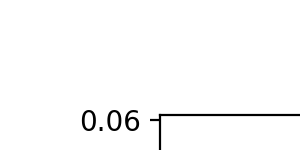

In [38]:
# Visalize the bar dtaset in 2D using optimal k value
fig_bar = plt.figure()
vis_v = VIS_Bars(data = data_bar ,proj = Y_bar ,
fig_vis = fig_bar ,         
         image_size = image_size ,
         both = True)

**Describe what you observe from those embedded coordinates in terms
of manifold learning.**

Visual inspection shows that this configuration space is well approximated by a two-dimensional manifold, as the dots in the 2D plot correspond accurately to the bars in the figure next to it. For example, when clicking on the upper red data points, a horizontal bar appears on the lower part of the bar plot, as it's inverted, and when clicking on the blue data points, a vertical bar appears. When choosing data points next to each other, the corresponding bar moves correctly by changing position according to how close the data points we clicked on are.


### <span style="color:red">============ End of Assignment 7 =========== </span>